# Milk adulteration

```
题目： 基于拉曼光谱和k最近邻回归的羊奶掺假判别方法

摘要 Abstract
近年来，随着人们对营养及健康的重视，人们在乳制品的选择方面更倾向于选择羊奶来代替牛奶。然而，一些不良商家为了牟取暴利，在羊奶中掺假掺杂。采用拉曼光谱分析法检测羊奶中牛奶的含量，以0%、1%、2%、5%、10%、20%、40%、 60%、80%、100%的掺假率构建不同的样本。以掺假率作为预测目标，设计了基于K-最近邻回归模型的掺假判别模型。该模型与常用的线性回归和支持向量回归器等进行了对比，取得了预测最优效果。在测试集上的预测R2效应量分别为。。。。本文提供了一种快速、高效、准确的羊奶掺假的判别技术。。。 

图文摘要 Graphical abstract
放整体研究和方法框架

1.简介 Introduction
背景、羊奶vs牛奶，羊奶掺假问题、现有判别技术。。。，引出拉曼光谱的优势

2.材料与方法 Materials and methods
2.1.样品采集与制备 Samples collection and preparation
羊奶牛奶的来源、如何掺假
2.2拉曼光谱分析 Raman spectral analysis
介绍仪器
数据集描述性统计； 绘制不同掺假比例羊奶牛奶的平均波形
2.3预测模型
KNR原理介绍，特点/优势/缺点等

3.结果与讨论 Results and discussion


3.1数据分割 Data Splitting
Stratified Kennardstone Split

3.2 线性回归 / Ridge / LASSO / SVR / RF / KNR
介绍，分析
超参数如何选择

4.结论 Conclusions
什么方法效果比较好、
回扣背景问题，研究的意义

致谢 Acknowledgments
参考文献 References

```

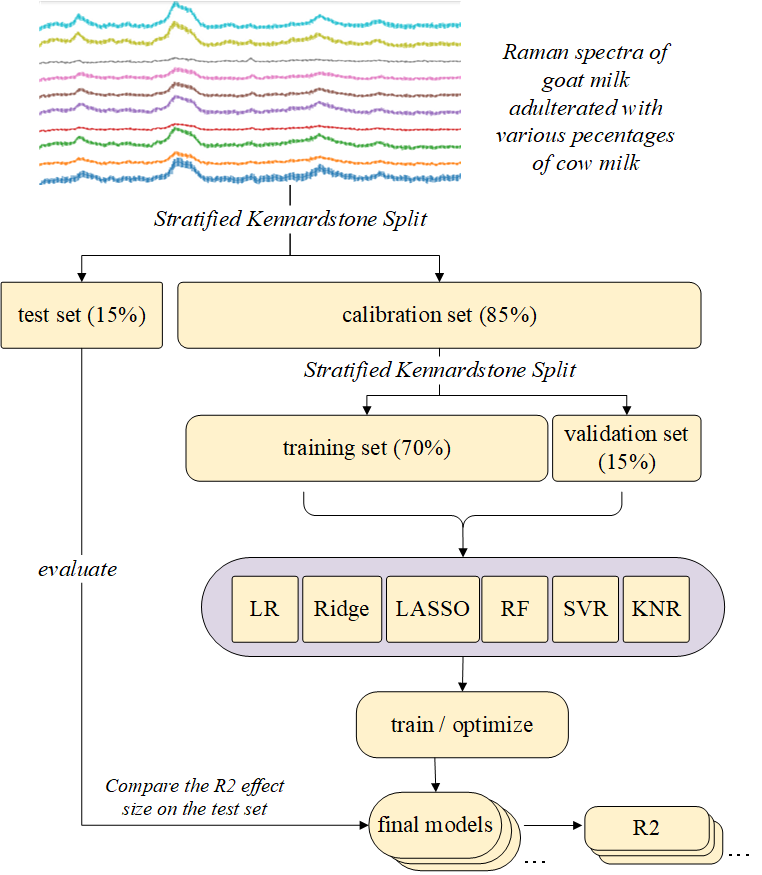

In [1]:
import qsi
qsi.__version__

'1.3.0'

load dataset from adulteration.CSV
X.shape (500, 1300)  y.shape (500,)
羊奶掺杂不同比例牛奶的拉曼光谱

yangniu0% label=0
yangniu1% label=1
yangniu2% label=2
yangniu5% label=3
yangniu10% label=4
yangniu20% label=5
yangniu40% label=6
yangniu60% label=7
yangniu80% label=8
yangniu100% label=9

"Goat milk is higher in fat and calories when compared to cow milk, and it also contains more protein, vitamins and minerals. 
When compared, goat milk also has about 1% less lactose than cow milk."
goats' milk is almost five times as expensive as cows' milk.  

The goat milk is from M company (Mengyang) and the cow milk is from T company (Telunsu).
No module named 'rpy2'


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10000000.0, residual penalty asymetry = 0.01)


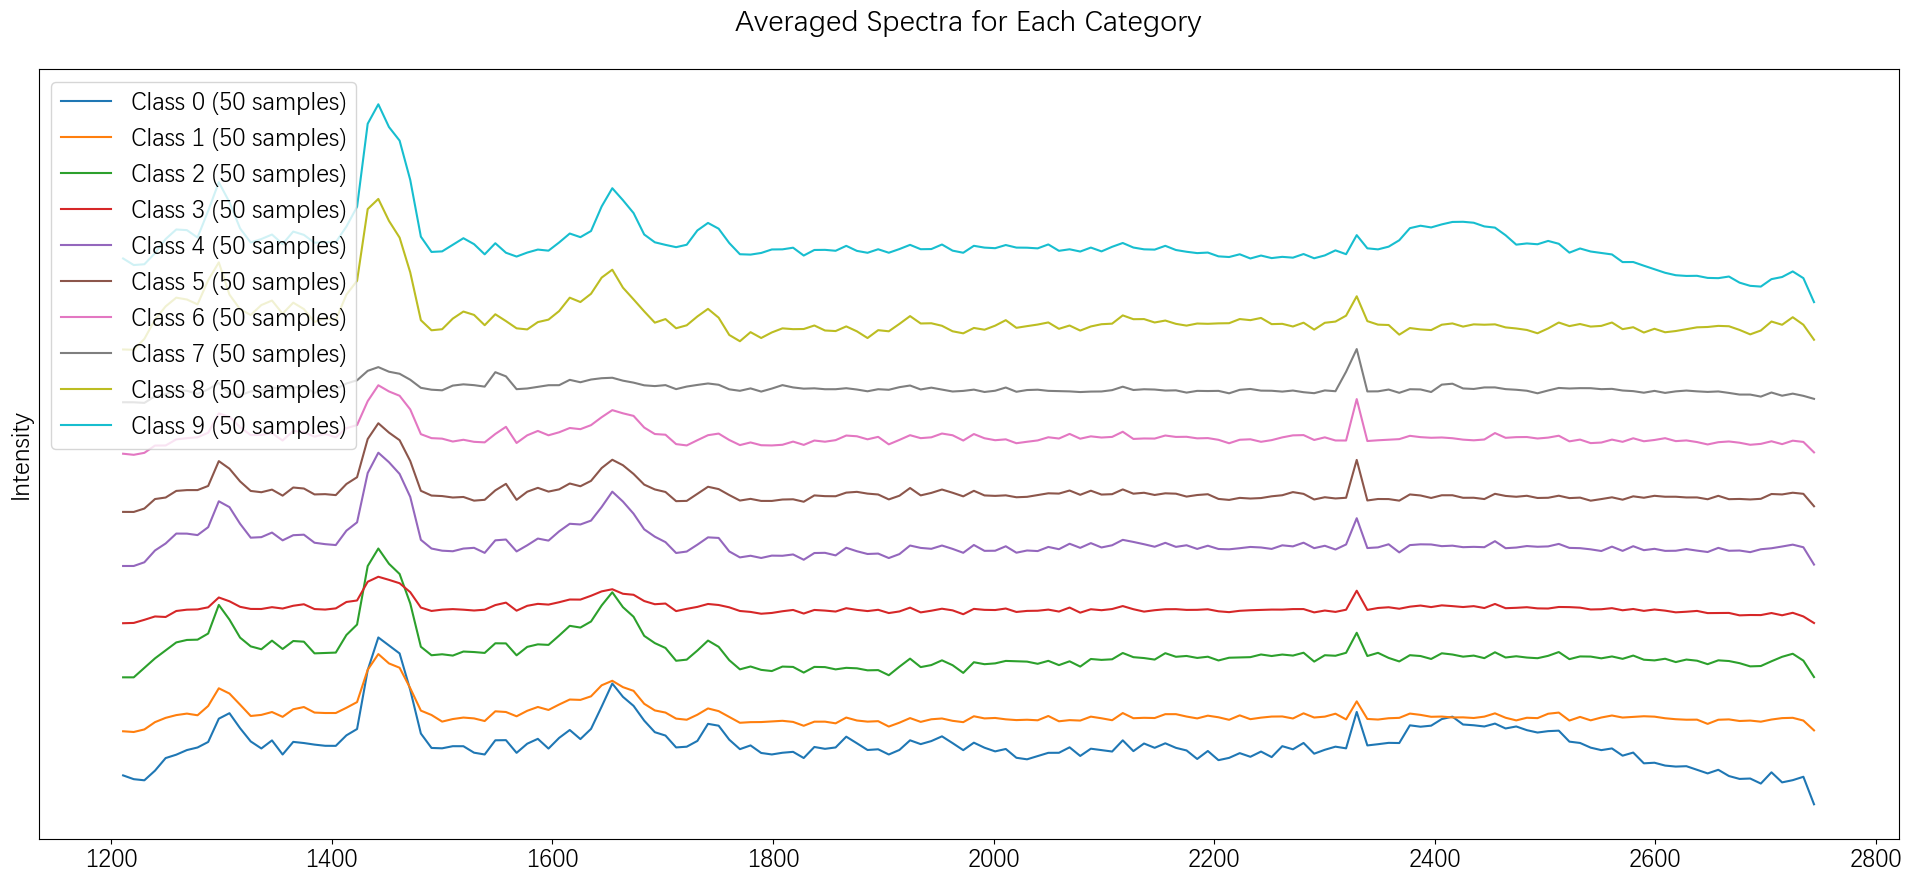

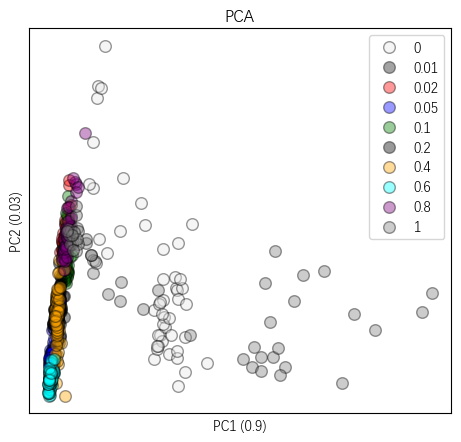

In [2]:
from qsi import io
X, yc, X_names, _, labels = io.load_dataset('milk_adulteration', x_range = list(range(100,1400)), display=False)

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, pres = [('max', 0.2),('baseline_removal', (1e7, 1e-2))])

io.draw_class_average(X[:,100:], yc, X_names[100:], labels=labels, SD=0, shift=100)
_ = io.scatter_plot(X, yc, labels=labels)

In [3]:
labels

['0', '0.01', '0.02', '0.05', '0.1', '0.2', '0.4', '0.6', '0.8', '1']

In [4]:
import numpy as np
y = np.asfarray(np.array(labels)[yc]) # convert class label to continuous value

# Stratified Kennardstone Split

保持分割后的数据集在y上的分布相同

参考： https://hxhc.xyz/post/kennardstone-spxy/

In [5]:
from qsi.io.pre import stratified_kennardstone_split # kennardstone_split
X_cal, X_test, y_cal, y_test = stratified_kennardstone_split(X, yc, 0.15)
X_train, X_val, y_train, y_val = stratified_kennardstone_split(X_cal, y_cal, 0.2)
y_train = np.asfarray(np.array(labels)[y_train])
y_val = np.asfarray(np.array(labels)[y_val])
y_test = np.asfarray(np.array(labels)[y_test])

In [6]:
y_train.shape, y_val.shape, y_test.shape

((340,), (80,), (80,))

# Regression

In [7]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

def draw_plot(yt, yp, title):

    plt.figure()
    plt.title(title + '\n' + 'R2 =' + str(round(r2_score(yt, yp),3)) + ', MSE =' + str(round(mean_squared_error(yt, yp),3)))
    plt.scatter(range(len(yt)), yt, label = 'ground truth')
    plt.scatter(range(len(yp)), yp, label='prediction')
    plt.legend()
    plt.show()


    # 绘制预测值与真实值的散点图
    plt.figure(figsize = (6,6))
    plt.scatter(yt, yp)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    
    # 计算残差
    residuals = yt - yp
    
    # 绘制残差图
    plt.figure()
    plt.scatter(yt, residuals)
    plt.xlabel('True values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuals')
    plt.show()

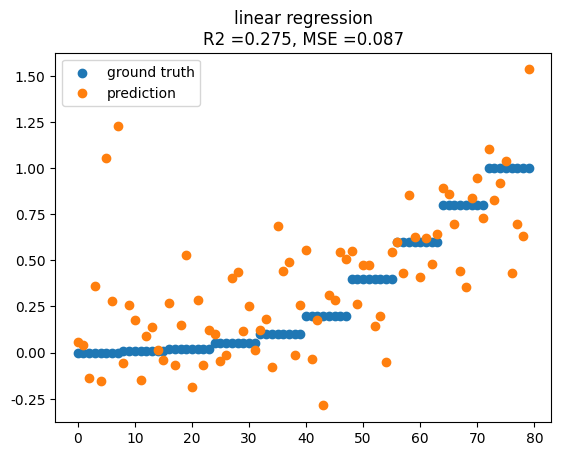

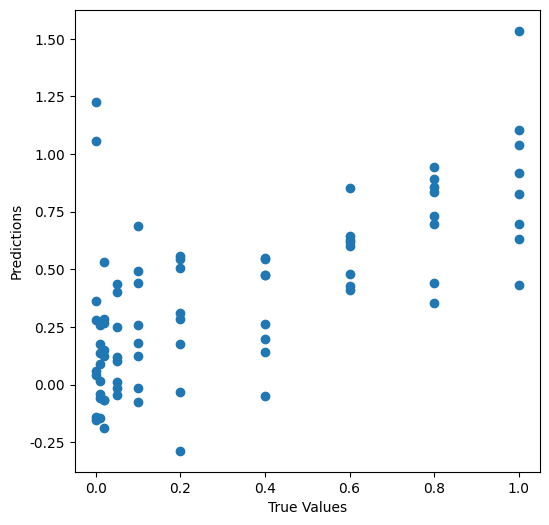

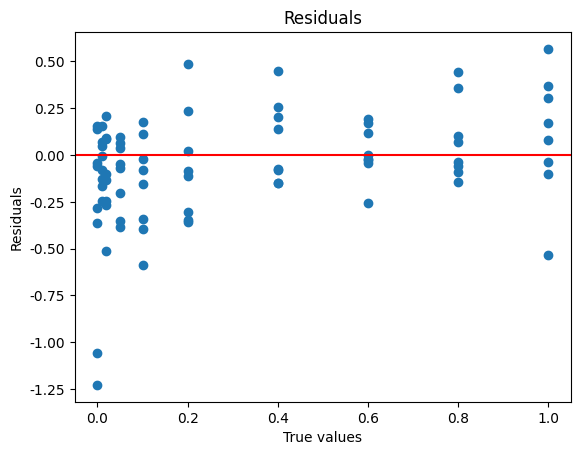

In [8]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

lr = LinearRegression()
yp = lr.fit(X_train, y_train).predict(X_test)

draw_plot(y_test, yp, title = 'linear regression')

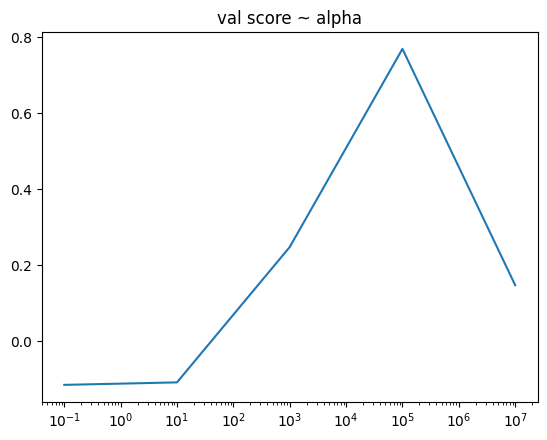

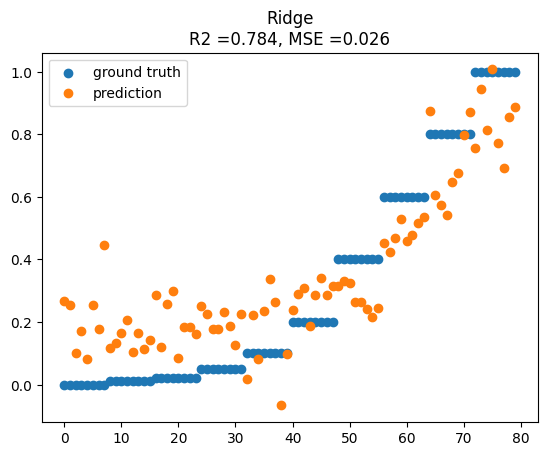

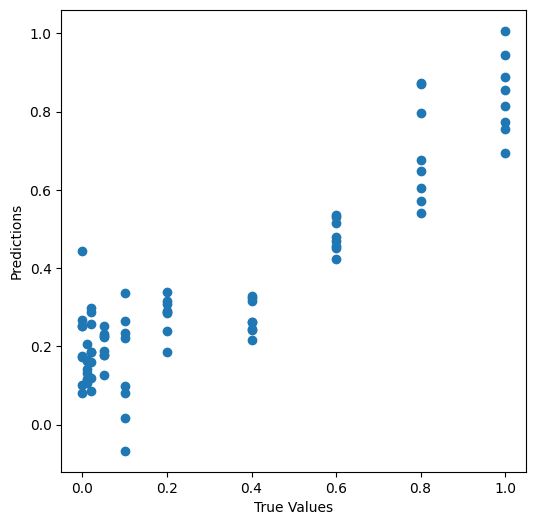

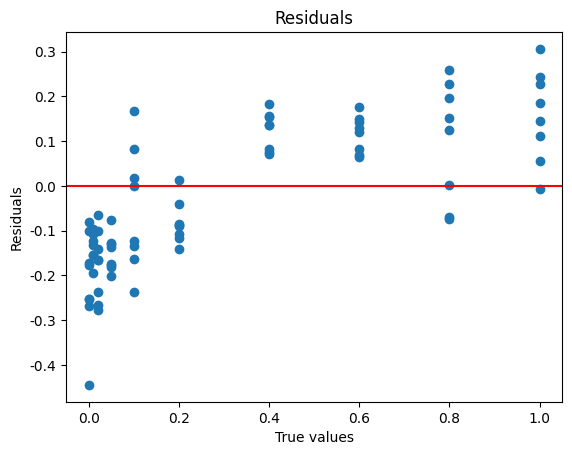

In [9]:
# Ridge
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

hparams = [.1, 10, 1000, 100000, 10000000]
val_scores = []
for alpha in hparams:
    ridge = Ridge(alpha = alpha).fit(X_train, y_train)
    val_scores.append(ridge.score(X_val, y_val))

plt.title('val score ~ alpha')
plt.xscale('log')
plt.plot(hparams, val_scores)
plt.show()

best_hparam = hparams[np.argmax(val_scores)]
ridge = Ridge(alpha = best_hparam).fit(X_train, y_train)

# print('test score:', ridge.score(X_test, y_test))
yp = ridge.predict(X_test)
draw_plot(y_test, yp, title = 'Ridge')

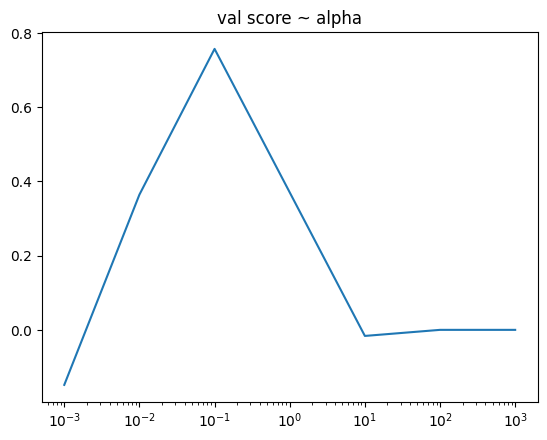

test score: 0.7798685417835786


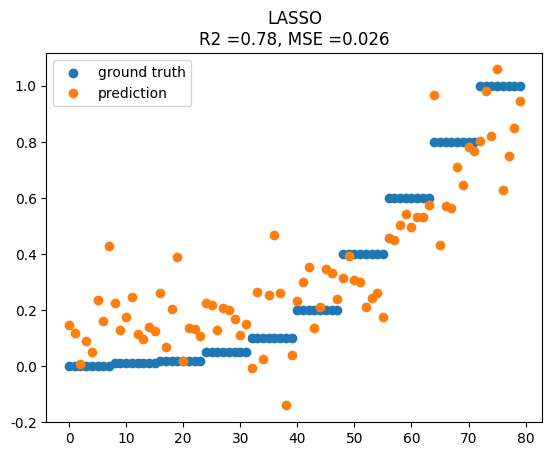

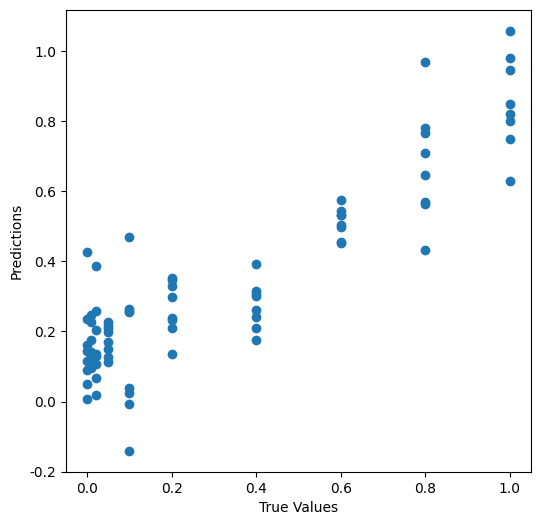

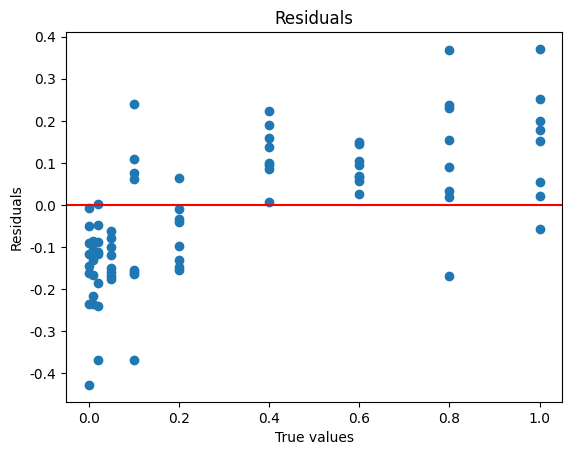

In [10]:
# LASSO
from sklearn.linear_model import Lasso, LassoCV
import matplotlib.pyplot as plt


hparams = [.001, .01, .1, 10, 100, 1000]
val_scores = []
for alpha in hparams:
    lasso = Lasso(alpha = alpha).fit(X_train, y_train)
    val_scores.append(lasso.score(X_val, y_val))

plt.title('val score ~ alpha')
plt.xscale('log')
plt.plot(hparams, val_scores)
plt.show()

best_hparam = hparams[np.argmax(val_scores)]
lasso = Lasso(alpha = best_hparam).fit(X_train, y_train)

lasso = Lasso(alpha = 0.1).fit(X_train, y_train)
print('test score:', lasso.score(X_test, y_test))

yp = lasso.predict(X_test)
draw_plot(y_test, yp, title = 'LASSO')

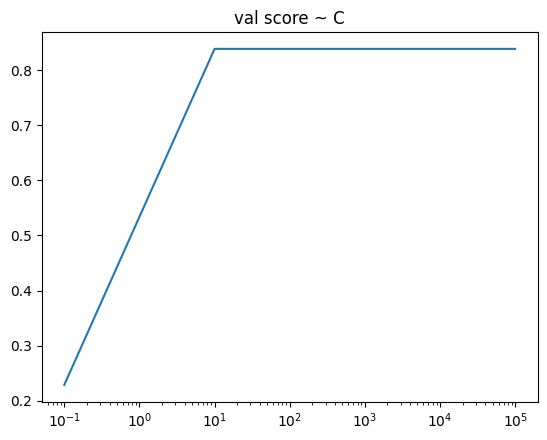

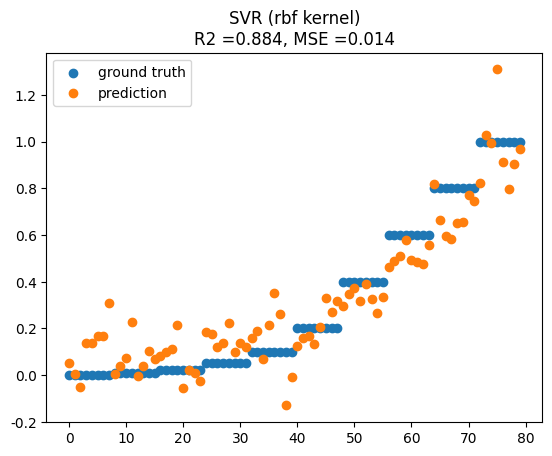

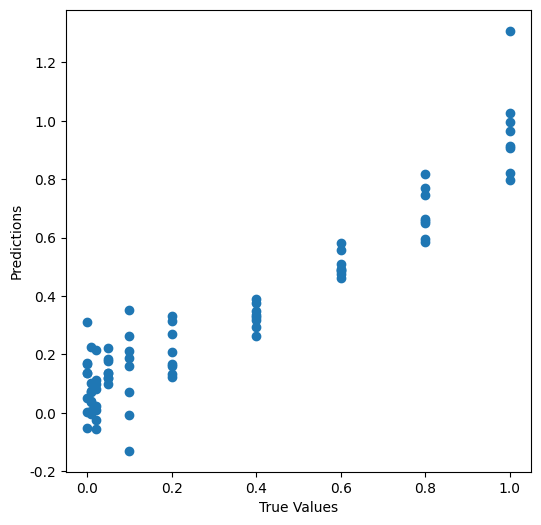

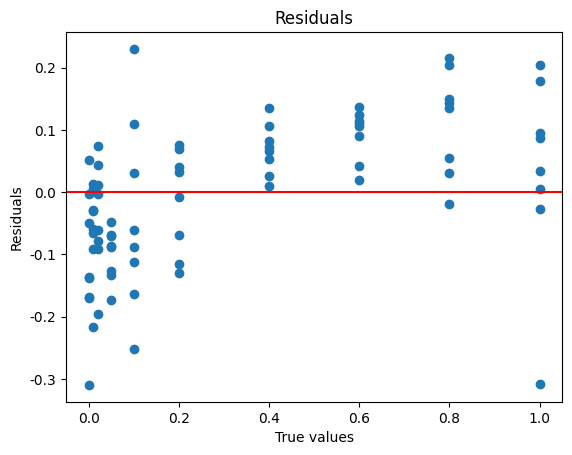

In [11]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt


Cs = [ .1, 10, 100, 1000, 10000, 100000]
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'rbf', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

plt.title('val score ~ C')
plt.xscale('log')
plt.plot(Cs, val_scores)
plt.show()

best_hparam = Cs[np.argmax(val_scores)]
svr = SVR(kernel = 'rbf', C=best_hparam)
yp = svr.fit(X_train, y_train).predict(X_test)

draw_plot(y_test, yp, title = 'SVR (rbf kernel)')

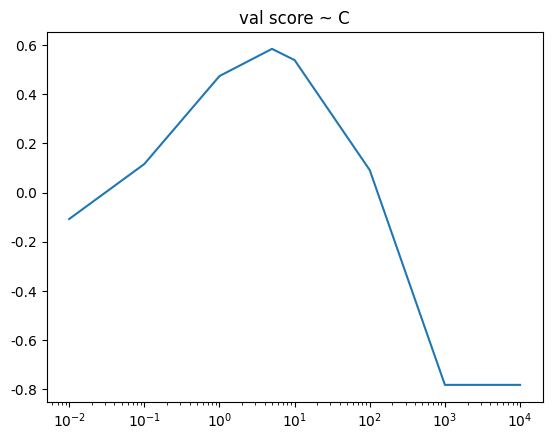

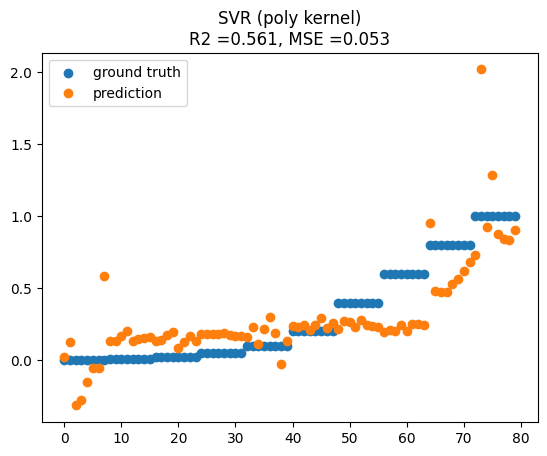

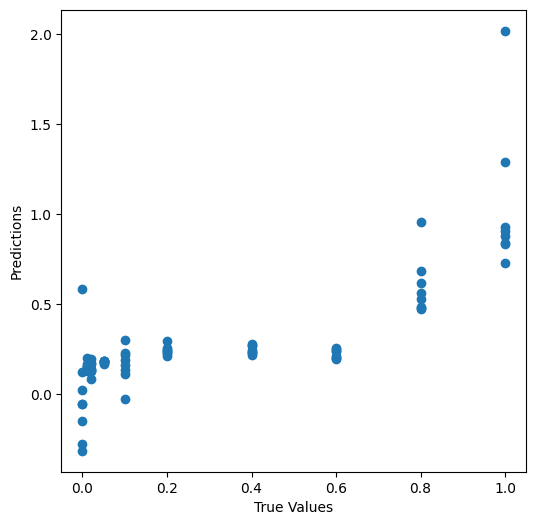

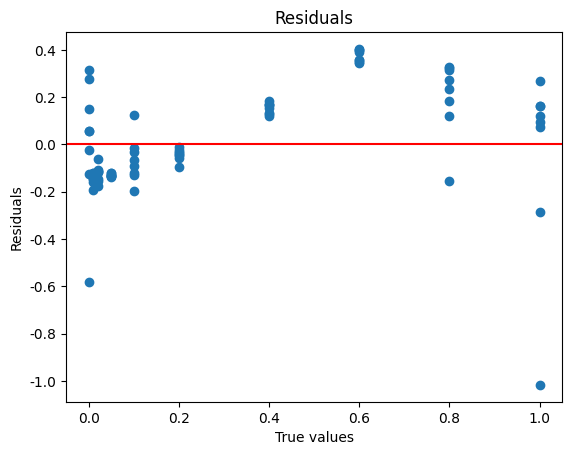

In [12]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

Cs = [.01, .1, 1, 5, 10, 100, 1000, 10000]
val_scores = []
for C in Cs:
    svr = SVR(kernel = 'poly', C=C).fit(X_train, y_train)
    val_scores.append(svr.score(X_val, y_val))

plt.title('val score ~ C')
plt.xscale('log')
plt.plot(Cs, val_scores)
plt.show()

best_hparam = Cs[np.argmax(val_scores)]
svr = SVR(kernel = 'poly', C=best_hparam)
yp = svr.fit(X_train, y_train).predict(X_test)

draw_plot(y_test, yp, title = 'SVR (poly kernel)')

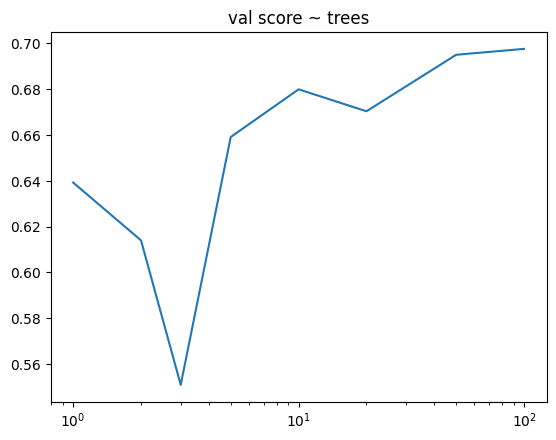

Training set R2:  0.6636319123280328
Test set R2: 0.723565750879211


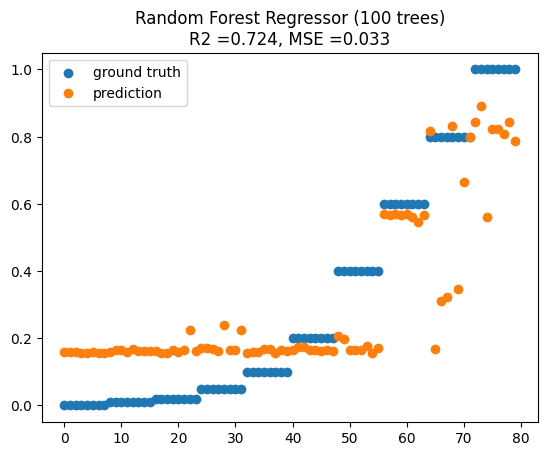

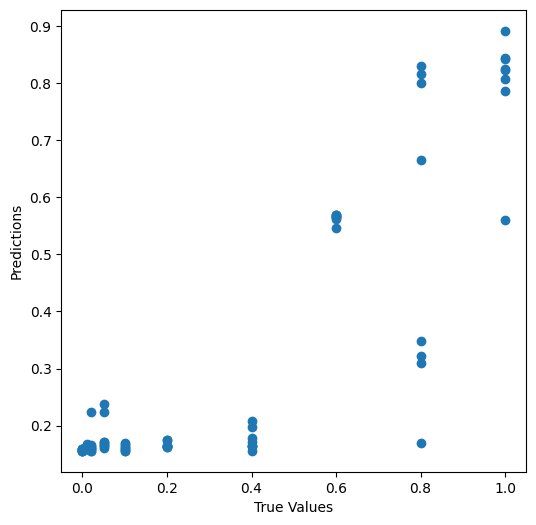

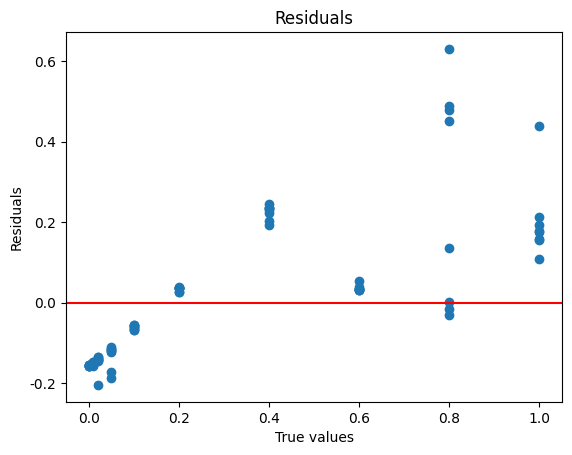

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Each run is random. The result is very unstable

Ns = [1, 2, 3, 5, 10, 20, 50, 100]
val_scores = []
for N in Ns:
    rf_regressor = RandomForestRegressor(n_estimators = N, max_depth = 2).fit(X_train, y_train)
    val_scores.append(rf_regressor.score(X_val, y_val))

plt.title('val score ~ trees')
plt.xscale('log')
plt.plot(Ns, val_scores)
plt.show()

best_hparam = Ns[np.argmax(val_scores)]
rf_regressor = RandomForestRegressor(n_estimators = best_hparam, max_depth = 2)
rf_regressor.fit(X_train, y_train)

y_pred_train = rf_regressor.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = rf_regressor.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))

draw_plot(y_test, y_pred, title = 'Random Forest Regressor (' + str(best_hparam) + ' trees)')

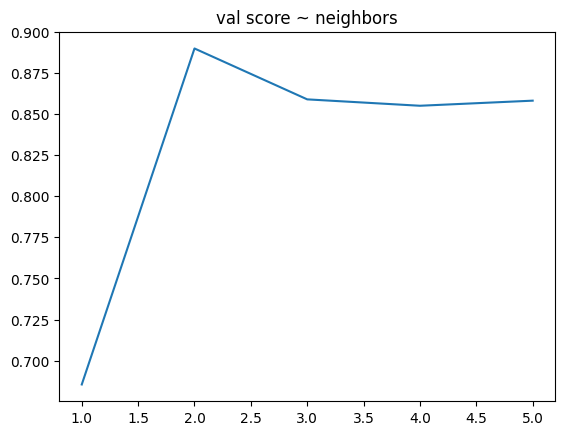

Training set R2:  0.873160638906075
Test set R2: 0.8934754027426441


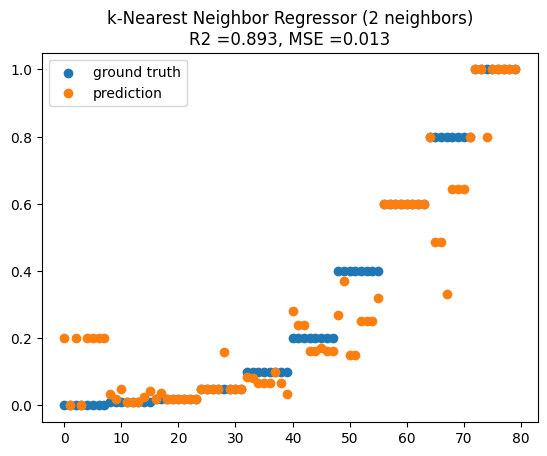

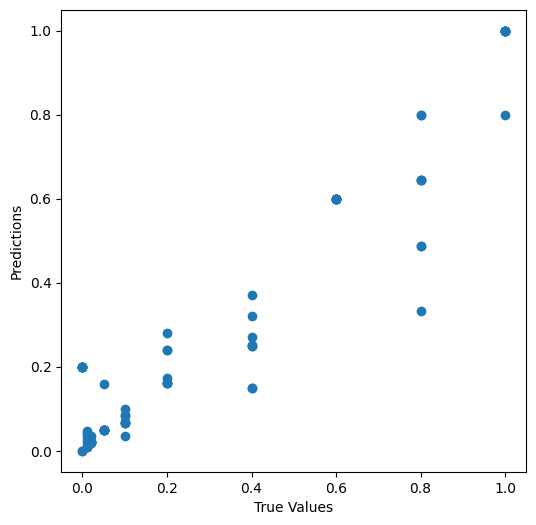

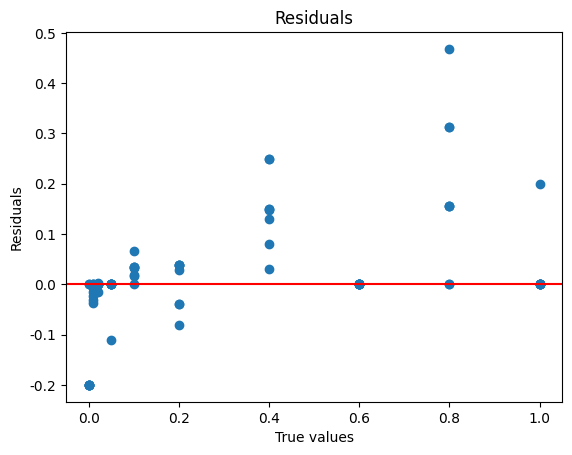

In [14]:
from sklearn.neighbors import KNeighborsRegressor

# param_grid = {
#     'n_neighbors': [1, 2, 3, 4, 5, 10],
#     'metric': ['l1', 'l2', 'chebyshev', 'cosine'], # l1 - manhattan / cityblock, l2 - euclidean 
#}

Ns = [1, 2, 3, 4, 5]
val_scores = []
for N in Ns:
    knr = KNeighborsRegressor(n_neighbors = N).fit(X_train, y_train)
    val_scores.append(knr.score(X_val, y_val))

plt.title('val score ~ neighbors')
# plt.xscale('log')
# .set_major_locator(MaxNLocator(integer=True))
plt.plot(Ns, val_scores)
plt.show()

best_hparam = Ns[np.argmax(val_scores)]

knr = KNeighborsRegressor(n_neighbors = N).fit(X_train, y_train)

y_pred_train = knr.predict(X_train)
print('Training set R2: ', r2_score(y_train, y_pred_train))

y_pred = knr.predict(X_test)
print('Test set R2:', r2_score(y_test, y_pred))

draw_plot(y_test, y_pred, title = 'k-Nearest Neighbor Regressor (' + str(best_hparam) +' neighbors)')